## Malware Visualization

In [ ]:
import os
from math import ceil
import numpy as np
from PIL import Image

def get_image_width(file_size):
    if file_size < 10 * 1024:
        return 32
    elif file_size < 30 * 1024:
        return 64
    elif file_size < 60 * 1024:
        return 128
    elif file_size < 100 * 1024:
        return 256
    elif file_size < 200 * 1024:
        return 384
    elif file_size < 500 * 1024:
        return 512
    elif file_size < 1000 * 1024:
        return 768
    else:
        return 1024

def convert_and_save(array, output_path, image_width):
    print(f'Processing: {output_path}')
    
    height = ceil(array.shape[0] * 16 / image_width)
    padded_array = np.pad(array.flatten(), (0, image_width * height - len(array.flatten())), mode='constant', constant_values=0)
    reshaped_array = padded_array.reshape(height, image_width)
    
    image = Image.fromarray(np.uint8(reshaped_array))
    image.save(output_path)
    print(f'Saved image: {output_path}')
    return image

# 主程序
root = './dataSample'  # 包含 .bytes 文件的資料夾
output_dir = './outputImages' #輸出資料夾
os.makedirs(output_dir, exist_ok=True)

files = os.listdir(root)
print('Processing files:', files)

# 處理 .bytes 文件
for name in files:
    if not name.endswith('.bytes'):
        continue
    
    file_path = os.path.join(root, name)
    output_path = os.path.join(output_dir, f'{os.path.splitext(name)[0]}.png')
    
    file_size = os.path.getsize(file_path)
    image_width = get_image_width(file_size)
    
    array = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 17: 
                continue
            array.append([int(i, 16) if i != '??' else 0 for i in parts[1:]])
    
    array = np.array(array)
    convert_and_save(array, output_path, image_width)

Processing files: ['0A32eTdBKayjCWhZqDOQ.asm', '0A32eTdBKayjCWhZqDOQ.bytes', '0ACDbR5M3ZhBJajygTuf.asm', '0ACDbR5M3ZhBJajygTuf.bytes']
Processing: ./outputImages\0A32eTdBKayjCWhZqDOQ.png
Saved image: ./outputImages\0A32eTdBKayjCWhZqDOQ.png
Processing: ./outputImages\0ACDbR5M3ZhBJajygTuf.png
Saved image: ./outputImages\0ACDbR5M3ZhBJajygTuf.png


## GIST特徵

In [24]:
import torch
import numpy as np
from torch.fft import fft2, ifft2, fftshift
from torchvision.transforms import functional as TF
from PIL import Image
import matplotlib.pyplot as plt


class GISTFeatureExtractor:
    def __init__(self, orientations=8, scales=4, blocks=4, boundary_extension=16, device="cuda"):
        """
        初始化 GIST 特徵提取器
        :param orientations: 濾波器方向數
        :param scales: 濾波器尺度數
        :param blocks: 圖像分割的區塊數 (blocks x blocks)
        :param boundary_extension: 圖像邊界填充大小
        :param device: 運算設備 ('cuda' 或 'cpu')
        """
        self.orientations = orientations
        self.scales = scales
        self.blocks = blocks
        self.boundary_extension = boundary_extension
        self.device = device

    def create_gabor_filters(self, image_size):
        """
        創建 Gabor 濾波器組
        """
        filters = []
        fx, fy = torch.meshgrid(
            torch.linspace(-0.5, 0.5, image_size[0], device=self.device),
            torch.linspace(-0.5, 0.5, image_size[1], device=self.device)
        )
        fr = torch.sqrt(fx**2 + fy**2)
        t = torch.atan2(fy, fx)

        for scale in range(self.scales):
            sigma = 0.35 * (0.8 ** scale)
            for orientation in range(self.orientations):
                theta = orientation * np.pi * 2 / self.orientations
                tr = t - theta
                tr = (tr + np.pi) % (2 * np.pi) - np.pi
                gabor = torch.exp(
                    -10 * ((fr / sigma - 1)**2) - 2 * np.pi * (tr**2)
                )
                filters.append(gabor)
        return filters

    def preprocess_image(self, image_tensor):
        """
        圖像預處理：調整大小 + 歸一化 + 邊界填充
        """
        image_tensor = image_tensor - image_tensor.min()
        if image_tensor.max() > 0:
            image_tensor /= image_tensor.max()

        if image_tensor.ndim == 2:
            image_tensor = image_tensor.unsqueeze(0).unsqueeze(0)

        image_tensor = torch.nn.functional.pad(
            image_tensor, (self.boundary_extension,) * 4, mode="reflect"
        )

        return image_tensor.squeeze(0).squeeze(0)


    def downsample_blocks(self, response, blocks):
        """
        計算每個區域的平均值
        """
        h, w = response.shape[-2:]
        grid_h, grid_w = h // blocks, w // blocks
        downsampled = torch.zeros((blocks, blocks), device=self.device)
        for i in range(blocks):
            for j in range(blocks):
                block = response[
                    i * grid_h:(i + 1) * grid_h, j * grid_w:(j + 1) * grid_w
                ]
                downsampled[i, j] = block.mean()
        return downsampled
    
    def visualize_gabor_responses(self, image, filters):
        """
        將 Gabor 濾波器應用於圖像，並以表格形式顯示濾波結果
        """
        fig, axes = plt.subplots(self.scales, self.orientations, figsize=(15, 8))
        fig.suptitle("Gabor Filter Responses: Y-Scales, X-Orientations", fontsize=16)

        scale_labels = [f"Scale {i+1}" for i in range(self.scales)]
        direction_labels = [f"Dir {i+1}" for i in range(self.orientations)]

        for scale in range(self.scales):
            for orientation in range(self.orientations):
                idx = scale * self.orientations + orientation
                gabor_filter = filters[idx]
                response = ifft2(fft2(image) * fft2(gabor_filter)).abs()

                ax = axes[scale, orientation]
                ax.imshow(response.cpu(), cmap="gray")
                
                if orientation == 0:
                    ax.set_ylabel(scale_labels[scale], rotation=90, fontsize=10, labelpad=10)
                
                if scale == self.scales - 1:
                    ax.set_xlabel(direction_labels[orientation], fontsize=10)

                ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    def extract_gist_features(self, image):
        """
        提取 GIST 特徵向量
        """
        image = self.preprocess_image(image)
        image_size = image.shape[-2:]
        filters = self.create_gabor_filters(image_size)

        features = []
        for gabor_filter in filters[:20]:
            response = ifft2(fft2(image) * fft2(gabor_filter)).abs()
            response_blocks = self.downsample_blocks(response, self.blocks)
            features.append(response_blocks.flatten())
        
        gist_vector = torch.cat(features)
        return gist_vector



In [25]:
orientations = 8
scales = 4
blocks = 4
boundary_extension = 16
device = "cuda" if torch.cuda.is_available() else "cpu"

In [26]:
image_path = "example.jpg"
image = Image.open(image_path).convert("L")
image_tensor = torch.tensor(np.array(image), dtype=torch.float32, device=device)

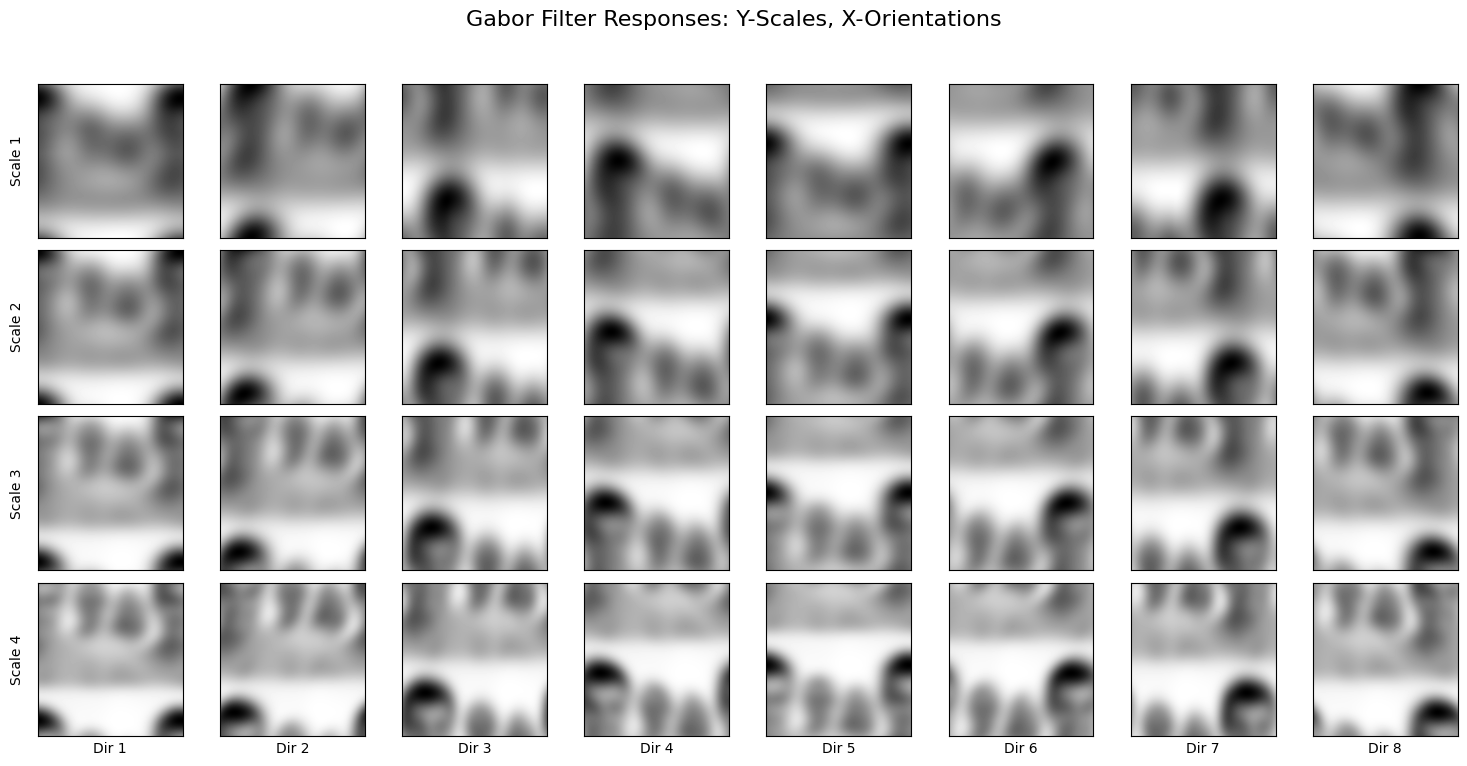

In [ ]:
gist_extractor = GISTFeatureExtractor(orientations, scales, blocks, boundary_extension, device)
preprocessed_image = gist_extractor.preprocess_image(image_tensor)

image_size = preprocessed_image.shape[-2:]
gabor_filters = gist_extractor.create_gabor_filters(image_size)

gist_extractor.visualize_gabor_responses(preprocessed_image, gabor_filters)
del gist_extractor

In [6]:
# 提取 GIST 特徵
gist_extractor = GISTFeatureExtractor(orientations, scales, blocks, boundary_extension, device)
gist_features = gist_extractor.extract_gist_features(image_tensor)

# 打印結果
print("GIST 特徵向量維度:", gist_features.shape)
print("GIST 特徵向量:", gist_features.cpu().numpy())

GIST 特徵向量維度: torch.Size([320])
GIST 特徵向量: [1384.5653   981.6769   927.418   1061.8002   836.28015  799.7992
  900.8886   801.58093  837.33344  792.2143   808.9005   817.6226
 1379.8567   983.9283   893.7002  1139.2727   962.6877  1157.3468
  904.146    938.4155   798.657    814.1577   792.47076  885.9418
  909.3452  1009.5481   873.8012   843.0158  1220.7963  1602.4827
 1033.9174   939.8608   808.36255  821.0698   747.04016  864.17993
  846.5697  1012.979    893.3092   831.21063  929.9194  1611.0212
 1133.4873   966.2389   832.03424 1206.0353   905.67145  967.8434
  940.86115  990.9573   858.917    839.7696  1237.0277  1587.9579
 1041.8177   928.9529   922.95044 1197.5198   925.56494  944.181
  796.72015  819.9852   782.0838   896.7225  1218.5057   934.9599
  867.67584 1051.0123  1509.0426  1021.0075   930.80084 1147.9634
  919.86884  832.31055  910.81824  834.4462   806.5853   774.41925
  824.1934   795.4767   874.7972   842.45764  905.9668  1007.2834
 1037.0083   941.28064 1208.3645 

In [7]:
def load_dataset(dataset_path, gist_extractor):
    data = []
    labels = []
    label_map = {}
    current_label = 0

    for family in os.listdir(dataset_path):
        family_path = os.path.join(dataset_path, family)
        if not os.path.isdir(family_path):
            continue

        if family not in label_map:
            label_map[family] = current_label
            current_label += 1

        for image_file in tqdm(os.listdir(family_path), desc=f"Processing {family}"):
            image_path = os.path.join(family_path, image_file)
            image = Image.open(image_path).convert("L")
            image_tensor = torch.tensor(np.array(image), dtype=torch.float32, device=gist_extractor.device)
            gist_features = gist_extractor.extract_gist_features(image_tensor)
            data.append(gist_features)
            labels.append(label_map[family])

    data = np.array([feature.cpu().numpy() for feature in data])
    labels = np.array(labels)

    return data, labels, label_map


## KNN分類

dataset來源: https://drive.google.com/file/d/1Ebb4OkEeBeh8Q0IAQ5sM9nto1Dhrarm3/view?usp=sharing

In [8]:
import os
import torch
import numpy as np
from torch.fft import fft2, ifft2
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm

from sklearn.metrics import accuracy_score

gist_extractor = GISTFeatureExtractor(device="cuda" if torch.cuda.is_available() else "cpu")

dataset_path = "./dataset" 
data, labels, label_map = load_dataset(dataset_path, gist_extractor)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

knn = KNeighborsClassifier(n_neighbors=3, metric="euclidean")

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("KNN 分類準確率:", accuracy)

Processing Yuner.A: 100%|██████████| 800/800 [00:15<00:00, 53.17it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


KNN 分類準確率: 0.9707664884135473


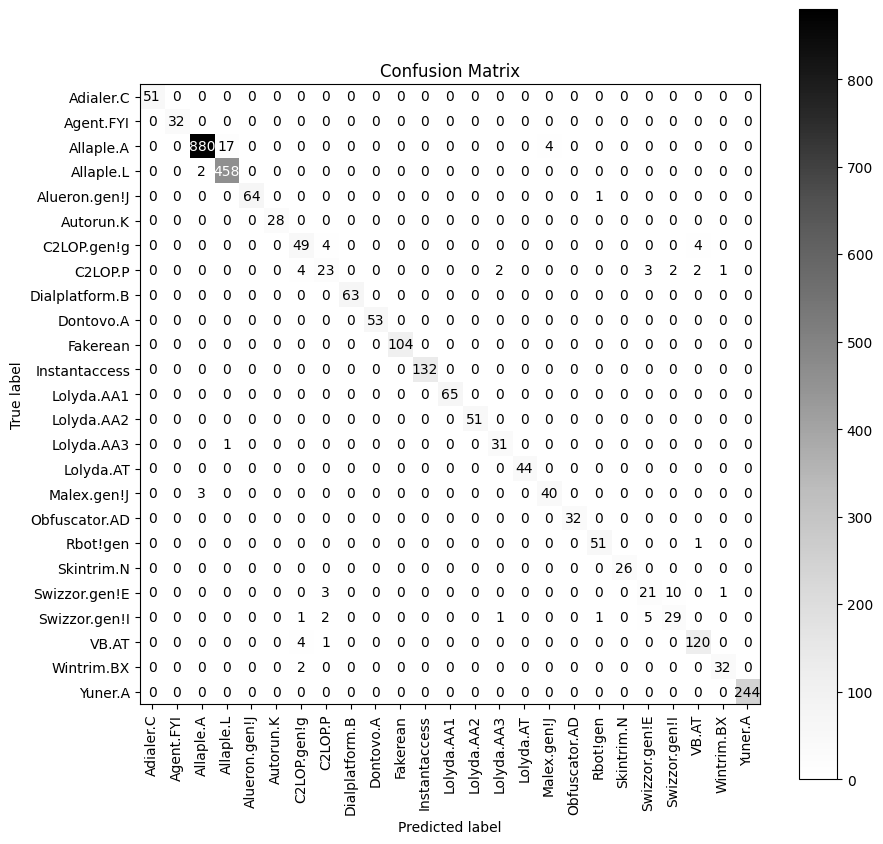

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_map.keys()))

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Greys, ax=ax)

plt.xticks(rotation=90)
plt.title("Confusion Matrix")
plt.show()

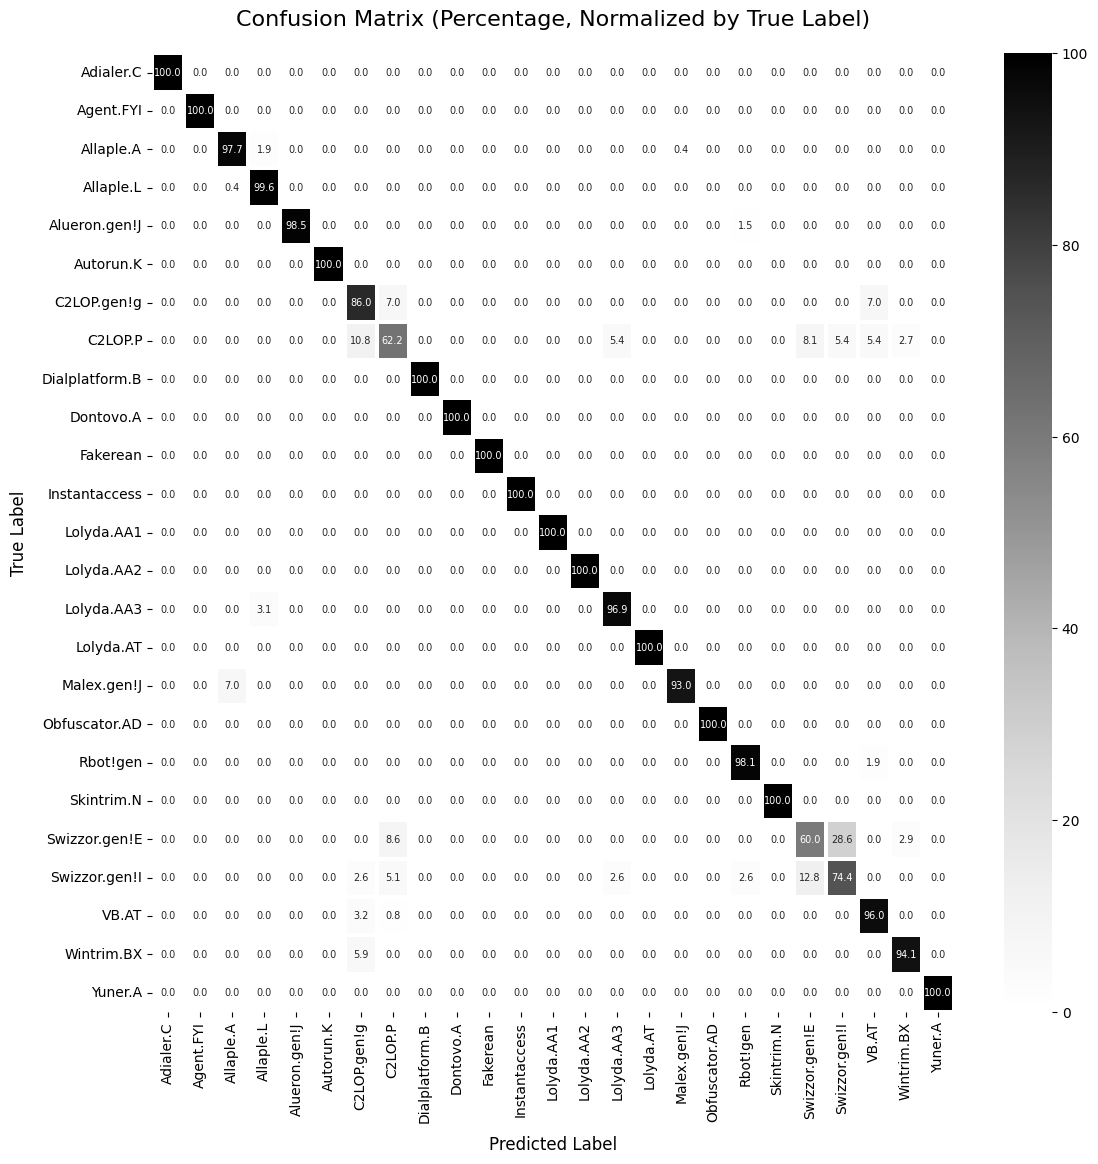

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # 以 True label 行總和歸一化

labels = list(label_map.keys())

fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(cm_percentage, 
            annot=True, 
            fmt=".1f", 
            cmap="Greys", 
            xticklabels=labels, 
            yticklabels=labels, 
            cbar=True, 
            linewidths=1.5,
            linecolor='white',
            annot_kws={"size": 7})

# 調整標籤顯示
plt.title("Confusion Matrix (Percentage, Normalized by True Label)", fontsize=16, pad=20)
plt.xlabel("Predicted Label", fontsize=12, labelpad=10)
plt.ylabel("True Label", fontsize=12, labelpad=10)
plt.xticks(rotation=90, fontsize=10) 
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout(pad=2.0)

plt.show()
